In [1]:
import random
import json
from math import floor, sqrt
import pandas as pd
import numpy as np
import functools
from IPython.core.display import HTML


from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec

import hdbscan
from sklearn.cluster import KMeans
# SpectralClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from sklearn.decomposition import TruncatedSVD

In [2]:
def split_train_test(doc_split=10000):
    """
    Loads data, splits into train and test set.
    Returns
    ----------
    train_labels: List[str]
    train_text: List[str]
    test_labels: List[str]
    test_text: List[str]
    """
    df = pd.read_csv('keywords_with_clean_txt.csv')
    df = df.dropna(subset='clean_text')
    # shuffle rows in dataframe
    df = df.sample(frac=1).reset_index(drop=True)
    df_train =df.loc[:doc_split, :]
    df_test = df.loc[doc_split:, :]
    # dataset is evenly distributed, hopefully fine split.
    train_labels = df_train.copy()["doc_path"].astype(str).to_list()
    train_text = df_train.copy()["clean_text"].astype(str).to_list()
    test_labels = df_test.copy()["doc_path"].astype(str).to_list()
    test_text = df_test.copy()["clean_text"].astype(str).to_list()
    return train_labels, train_text, test_labels, test_text

In [3]:
y_train, X_train, y_test, X_test = split_train_test()

In [4]:
TFIDF_VEC = TfidfVectorizer(input='content', max_df=0.90)
X_train = TFIDF_VEC.fit_transform(X_train)
SVD = TruncatedSVD(n_components=2)
X_reduced_dimensions = SVD.fit_transform(X_train)

In [5]:
SVD.explained_variance_ratio_

array([0.00170933, 0.00268625])

In [6]:
SVD.explained_variance_ratio_.sum()

0.004395576929100892

In [7]:
def print_top_svd_features(svd_component_index, num_words=20):
    feature_names = TFIDF_VEC.get_feature_names()
    best_features = [feature_names[i] for i in SVD.components_[svd_component_index].argsort()][::-1]
    return best_features[:num_words]

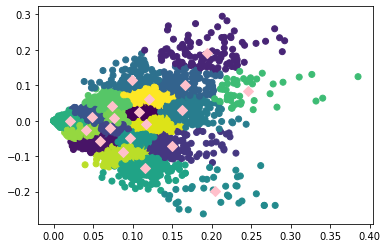

In [8]:

model = KMeans(n_clusters=20).fit(X_reduced_dimensions)
cluster_labels = model.predict(X_reduced_dimensions)
fig, axes = plt.subplots(nrows=1, ncols=1)
#flat_axes = axes.flatten()
name = "tab20b"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = cmap.colors  # type: list
for i in range(0, 1):
    #flat_axes[i].set_prop_cycle(color=colors)
    axes.scatter(X_reduced_dimensions[:, i], X_reduced_dimensions[:, i+1], c=cluster_labels)
centroids = model.cluster_centers_
centroid_x = centroids[:, 0]
centroid_y = centroids[:, 1]
axes.scatter(centroid_x, centroid_y, marker='D', s=50, color='pink')
plt.show()

Text(0, 0.5, 'Euclidean distance')

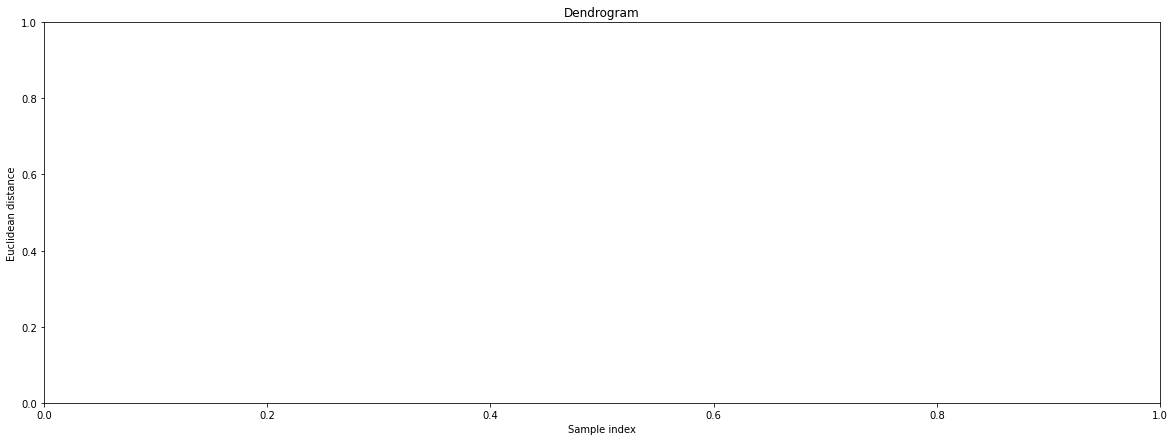

In [9]:
import scipy.cluster.hierarchy as sc

# Plot dendrogram
plt.figure(figsize=(20, 7))  
plt.title("Dendrograms")  

# Create dendrogram
clusters = sc.linkage(X_reduced_dimensions, method='ward')
a = sc.to_tree(clusters , rd=False)

plt.title('Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Euclidean distance')

In [10]:
plt.show()

In [11]:
# a represents a tree object. we can retrieve a path for a node using a recursive function....
a.get_count()
a.get_id()
print(a.get_right().get_right().get_id())
print(a.id)
print(a.right.id)

19997
20000
19999


https://stackoverflow.com/questions/19964266/scipy-dendrogram-to-json-for-d3-js-tree-visualisation

In [12]:
# Create a nested dictionary from the ClusterNode's returned by SciPy
def add_node(node, parent):
    # First create the new node and append it to its parent's children
    newNode = dict( node_id=node.id, children=[] )
    parent["children"].append( newNode )

    # Recursively add the current node's children
    if node.left: 
        add_node( node.left, newNode )
        
    if node.right: 
        add_node( node.right, newNode )

In [13]:
d3Dendro = dict(children=[], name="Root1")
add_node(a, d3Dendro)
id2name = dict(zip(range(len(y_train)), ['_'.join(doc_path.split('/')[-2:]) for doc_path in y_train]))
print(id2name)

{0: 'talk.politics.mideast_75998.txt', 1: 'talk.politics.guns_55246.txt', 2: 'talk.politics.misc_178530.txt', 3: 'comp.sys.ibm.pc.hardware_60659.txt', 4: 'comp.windows.x_67370.txt', 5: 'comp.windows.x_67168.txt', 6: 'rec.sport.hockey_54201.txt', 7: 'talk.politics.guns_53349.txt', 8: 'comp.os.ms-windows.misc_9579.txt', 9: 'talk.politics.mideast_77353.txt', 10: 'talk.religion.misc_83943.txt', 11: 'sci.crypt_16004.txt', 12: 'sci.crypt_15621.txt', 13: 'talk.politics.mideast_76261.txt', 14: 'sci.med_58843.txt', 15: 'rec.sport.hockey_52630.txt', 16: 'soc.religion.christian_21770.txt', 17: 'sci.electronics_53871.txt', 18: 'sci.electronics_53948.txt', 19: 'comp.sys.ibm.pc.hardware_60399.txt', 20: 'rec.autos_101633.txt', 21: 'rec.sport.baseball_105052.txt', 22: 'rec.autos_101613.txt', 23: 'rec.autos_103804.txt', 24: 'misc.forsale_76046.txt', 25: 'comp.windows.x_68236.txt', 26: 'sci.electronics_54187.txt', 27: 'comp.windows.x_68234.txt', 28: 'talk.religion.misc_84246.txt', 29: 'rec.sport.basebal

In [14]:
# Label each node with the names of each leaf in its subtree
def label_tree( n ):
    # If the node is a leaf, then we have its name
    if len(n["children"]) == 0:
        leafNames = [ id2name[n["node_id"]] ]

    # If not, flatten all the leaves in the node's subtree
    else:
        leafNames = functools.reduce(lambda ls, c: ls + label_tree(c),
                                     n["children"], [])

    # Delete the node id since we don't need it anymore and
    # it makes for cleaner JSON
    del n["node_id"]

    # Labeling convention: "-"-separated leaf names
    n["name"] = name = "-".join(sorted(map(str, leafNames)))

    return leafNames

In [15]:
label_tree( d3Dendro["children"][0] )

['soc.religion.christian_21325.txt',
 'soc.religion.christian_21597.txt',
 'alt.atheism_53519.txt',
 'soc.religion.christian_20907.txt',
 'talk.religion.misc_84380.txt',
 'soc.religion.christian_21396.txt',
 'alt.atheism_51060.txt',
 'alt.atheism_52499.txt',
 'soc.religion.christian_21498.txt',
 'alt.atheism_53805.txt',
 'talk.religion.misc_84082.txt',
 'soc.religion.christian_20725.txt',
 'talk.religion.misc_83629.txt',
 'soc.religion.christian_20799.txt',
 'talk.religion.misc_84056.txt',
 'talk.religion.misc_83482.txt',
 'talk.politics.mideast_76030.txt',
 'alt.atheism_53298.txt',
 'soc.religion.christian_20790.txt',
 'soc.religion.christian_21681.txt',
 'soc.religion.christian_21565.txt',
 'soc.religion.christian_20937.txt',
 'soc.religion.christian_20938.txt',
 'soc.religion.christian_20722.txt',
 'soc.religion.christian_21765.txt',
 'soc.religion.christian_21408.txt',
 'soc.religion.christian_21714.txt',
 'soc.religion.christian_21550.txt',
 'soc.religion.christian_20803.txt',
 's

In [16]:
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=15).fit(X_reduced_dimensions)
labels = hdbscan_model.labels_
print(np.unique(labels))

[-1  0  1  2  3  4  5  6  7  8]


In [17]:
d3Dendro
json.dump(d3Dendro, open("d3-dendrogram.json", "w"), sort_keys=True, indent=4)

In [18]:
print(len(d3Dendro.keys()))

2


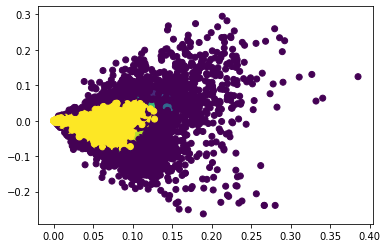

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=1)
#flat_axes = axes.flatten()
name = "tab20b"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = cmap.colors  # type: list
for i in range(0, 1):
    #flat_axes[i].set_prop_cycle(color=colors)
    axes.scatter(X_reduced_dimensions[:, i], X_reduced_dimensions[:, i+1], c=labels)
plt.show()

In [37]:
def get_tree_paths(root):
    if root is None: 
        return []
    if not root.left and not root.right:
        return [int(root.id)]

    # subtree is always a list, though it might be empty 
    left_subtree = get_tree_paths(root.left)  
    right_subtree = get_tree_paths(root.right)
    full_subtree = left_subtree + right_subtree  # the last part of comprehension
    
    list1 = []
    for leaf in full_subtree:  # middle part of the comprehension
        list1.append(str(root.id) + '-'+str(leaf))
    #   list1.append(leaf)# the left part 

    return list1

In [38]:
tree_paths = get_tree_paths(a)

In [39]:
print(tree_paths)


['20000-19998-19988-19970-19946-19822-19609-18738-5146', '20000-19998-19988-19970-19946-19822-19609-18738-9537', '20000-19998-19988-19970-19946-19822-19609-19142-904', '20000-19998-19988-19970-19946-19822-19609-19142-4276', '20000-19998-19988-19970-19946-19822-19770-9007', '20000-19998-19988-19970-19946-19822-19770-19650-3714', '20000-19998-19988-19970-19946-19822-19770-19650-18944-229', '20000-19998-19988-19970-19946-19822-19770-19650-18944-1791', '20000-19998-19988-19970-19946-19906-19706-1586', '20000-19998-19988-19970-19946-19906-19706-19025-959', '20000-19998-19988-19970-19946-19906-19706-19025-1432', '20000-19998-19988-19970-19946-19906-19849-19187-7236', '20000-19998-19988-19970-19946-19906-19849-19187-8968', '20000-19998-19988-19970-19946-19906-19849-19715-19365-9662', '20000-19998-19988-19970-19946-19906-19849-19715-19365-19176-17355-3231', '20000-19998-19988-19970-19946-19906-19849-19715-19365-19176-17355-5233', '20000-19998-19988-19970-19946-19906-19849-19715-19365-19176-176

In [50]:
leaf_to_path = {}
for tree_path in tree_paths:
    levels = tree_path.split('-')
    leaf_id = levels.pop()
    leaf_to_path[id2name[int(leaf_id)]] = levels



In [73]:
df = pd.DataFrame.from_dict(leaf_to_path, orient='index')
df.index.name = "document_name"
df.to_csv('document_to_path_mapping.csv')

In [53]:
# Now we can prune the Tree to the desired level we want

In [74]:
df.columns.tolist()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [75]:
# prune the tree, remove the root and go down to the fourth level to evaluate.
# time to plot this in a hierarchy
df = df[df.columns[1:5]]

In [76]:
df

,1,2,3,4
document_name,,,,
soc.religion.christian_21325.txt,19998,19988,19970,19946
soc.religion.christian_21597.txt,19998,19988,19970,19946
alt.atheism_53519.txt,19998,19988,19970,19946
soc.religion.christian_20907.txt,19998,19988,19970,19946
talk.religion.misc_84380.txt,19998,19988,19970,19946
...,...,...,...,...
comp.windows.x_67283.txt,19999,19997,19995,19989
sci.electronics_54165.txt,19999,19997,19995,19989
comp.os.ms-windows.misc_9914.txt,19999,19997,19995,19989


In [77]:
df.to_csv('results.txt')